In [1]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import re
import requests
import pathlib
import tspex

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests as r
import seaborn as sns
import xml.etree.ElementTree as ET

from Bio import SeqIO
from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
assay_list_path = "assay-list-olink-explore-3072.xlsx"
brain_rna_seq_path = "fe-wp-dataset-124.csv"
plate_layout_path = "Plate Layout.xlsx"
raw_data_path = "LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
uniprot_fasta_database = "uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"

In [3]:
plate_layout = pd.read_excel(plate_layout_path)

In [4]:
plate_layout

,Location,CSF_sample,Sample,SampleID,Patient_ID,Health
0,A01,CSF1,SEC Fract 6,SM-N8JPG,8351.0,Healthy
1,A02,CSF1,SEC Fract 7,SM-N8JPH,8351.0,Healthy
2,A03,CSF1,SEC Fract 8,SM-N8JPI,8351.0,Healthy
3,A04,CSF1,SEC Fract 9,SM-N8JPJ,8351.0,Healthy
4,A05,CSF1,SEC Fract 10,SM-N8JPK,8351.0,Healthy
...,...,...,...,...,...,...
91,H08,CSF8,SEC Fract 13,SM-N8JS2,8781.0,MCI
92,H09,CSF8,SEC Fract 14,SM-N8JS3,8781.0,MCI
93,H10,CSF8,SEC Fract 15,SM-N8JS4,8781.0,MCI
94,H11,Plasma D Internal EV,Plasma D Internal EV,SM-N8JS5,8712.0,AD


In [5]:
# uniprot_ids = []
# fasta_sequences = []

# assay_ids = list(assays["UniProt ID"])
# uniprot_ids = []
# fasta_sequences = []
# for cID in assay_ids:
#     baseUrl="http://www.uniprot.org/uniprot/"
#     currentUrl=baseUrl+cID+".fasta"
#     response = r.post(currentUrl)
#     cData=''.join(response.text)
#     uniprot_id = re.search(r'\|([^|]+)\|', cData)
#     if match:
#         uniprot_ids.append(uniprot_id.group(1))
#     fasta = cData.split('\n', 1)
#     if len(fasta) > 1:
#         fasta_sequences.extend(fasta[1].split('|'))
# formatted_fasta_sequences = [item.replace('\n', '') for item in fasta_sequences]

In [6]:
def parse_gz_file(file_path):
    """
    Creates a dictionary of UniProt IDs and their corresponding FASTA sequences using a .gz file.
    Parameters
    ----------
    file_path: path to a .gz file containing UniProt IDs and FASTA sequences.
    """
    protein_dict = {}
    current_uniprot_id = None
    current_sequence = ""
    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence
                    current_sequence = ""
                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()
                else:
                    print(f"Skipping line without expected format: {line}")
                    current_uniprot_id = None
            else:
                current_sequence += line
        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence
    return protein_dict

def tmhmm_localization(assays_path, output_directory):
    """
    Uses DeepTMHMM to characterize the localization of each amino acid in a protein. 
    Parameters
    ----------
    assays_path: .xlsx file path
        Path to a .xlsx file with a column containing the UniProt IDs of all the proteins in the Olink panel.
    """
    assays = pd.read_excel(assays_path)
    deeptmhmm = biolib.load("DTU/DeepTMHMM")
    with open("query.fasta", "w") as fasta_file:
        for _, row in assays.iterrows():
            fasta_line = f">{row['UniProt ID']}\n{row['Sequence']}\n"
            fasta_file.write(fasta_line)
        deeptmhmm_job = deeptmhmm.cli(args="--fasta query.fasta", machine="local")
        deeptmhmm_job.save_files(output_directory)


def identify_localization(assays, region, output_directory="olink_output"):
    """
    Identifies the localization of proteins using the output of DeepTMHMM.
    Parameters
    ----------
    assays : pandas.DataFrame
        DataFrame with columns called 'UniProt ID' and 'Sequence'
    region : {'TMhelix', 'inside', 'outside', 'internal', 'external'}
        Subcellular region requested. Options:
          - 'TMhelix': transmembrane proteins
          - 'inside': at least some of the protein is inside the cell/EV
          - 'outside': at least some of the protein is outside the cell/EV
          - 'internal': the protein is only found inside the cell, no transmembrane or outside domains
          - 'external': the protein is only found outside the cell, no transmembrane or inside domains
    output_directory: directory path
        Path to a directory in which the localization data will be stored.
    """
    output_directory_path = pathlib.Path(output_directory)
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    # os.chdir(output_directory)
    if not os.path.exists(output_directory_path / "TMRs.gff3"):
        tmhmm_localization(assays, output_directory_path)
    localization_df = pd.read_csv(
        output_directory_path / "TMRs.gff3",
        sep="\t",
        comment="#",
        names=[
            "uniprot_id",
            "region_location",
            "region_start",
            "region_end",
            0,
            1,
            2,
            3,
        ],
    )
    localization_df = localization_df[localization_df["uniprot_id"] != "//"].dropna(
        axis=1
    )
    get_regional_uniprots = lambda region: set(
        localization_df[localization_df["region_location"] == region]["uniprot_id"]
    )
    if region == "internal":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return inside_uniprots - tm_uniprots - outside_uniprots
    if region == "external":
        tm_uniprots = get_regional_uniprots("TMhelix")
        outside_uniprots = get_regional_uniprots("outside")
        inside_uniprots = get_regional_uniprots("inside")
        return outside_uniprots - inside_uniprots - tm_uniprots
    else:
        return get_regional_uniprots(region)


In [179]:
def calculate_mean(df):
    """
    Calculates the mean of all numeric values in a row of a dataframe, and assigns to a new column called "Mean".
    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe with columns containing numeric values.
    """
    return df.assign(Mean=df.mean(axis=1, numeric_only=True))


def map_hgnc_ids(brain_rna_seq_path):
    """
    Maps the HGNC IDs in the Brain RNA-Seq file to UniProt IDs.
    Parameters
    ----------
    brain_rna_seq_path: csv file path
        Path to the "homo sapiens.csv" file, downloaded from brainrnaseq.org.
    """
    hgnc_ids = (
        "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
    )
    brain_rna_seq = pd.read_csv(brain_rna_seq_path)

    hgnc_uniprot_mapping_data = pd.read_csv(
        (StringIO(requests.get(hgnc_ids).text)),
        sep="\t",
        usecols=["hgnc_id", "uniprot_ids"],
    )

    hgnc_uniprot_mapping_data['uniprot_ids'] = hgnc_uniprot_mapping_data['uniprot_ids'].str.split('|')
    hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data.explode('uniprot_ids')
    hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data.reset_index(drop=True)

    brain_rna_seq = pd.merge(
        brain_rna_seq,
        hgnc_uniprot_mapping_data,
        left_on="id",
        right_on="hgnc_id",
        how="inner",
    )
    brain_rna_seq.dropna(subset=["uniprot_ids"], inplace=True)
    brain_rna_seq.drop_duplicates(subset=["uniprot_ids"], inplace=True)

    return brain_rna_seq

def mean_cell_type(brain_rna_seq_data, cell_type):
    """
    Returns only the mean of the data for the specified cell type, as well as the UniProt ID information in an additional column
    Parameters
    ----------
    brain_rna_seq_data : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data
    cell_type : {'fetal', 'mature', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    """
    if cell_type == "microglia":
        microglia_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like="microglla").columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return microglia_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": "microglia"}
        )
    if cell_type == "astrocyte":
        astrocyte_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like="mature").columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return astrocyte_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": "astrocyte"}
        )
    else:
        cell_type_df = calculate_mean(
            brain_rna_seq_data[
                brain_rna_seq_data.filter(like=cell_type).columns.append(
                    pd.Index(["uniprot_ids"])
                )
            ]
        )[["uniprot_ids", "Mean"]]
        return cell_type_df.rename(
            columns={"uniprot_ids": "uniprot_ids", "Mean": cell_type}
        )


def cell_type_enrichment(
    brain_rna_seq_data,
    cell_type,
    specificity_metric,
    specificity_cutoff,
):
    """
    Parameters
    ----------
    'brain_rna_seq_data' : pandas.DataFrame
        Dataframe with a column called "uniprot_ids" (contains UniProt ID), and other columns containing cell-type specific Brain RNA Seq data for the cell types listed under cell_type
    'cell_type' : {'astrocyte', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    'specificity_metric': {
        'tsi',
        'zscore',
        'spm',
        'js_specificity'
    }
        Individualized metric of determining cell type specificity requested. Options:
        - 'tsi': tissue specificity index
        - 'zscore': z-score
        - 'spm': specificity measure
        - 'js_specificity': jensen-shannon specificity
    'specificity_cutoff' : numeric
        Numeric value representing the minimum value of the second enrichment cutoff.
    """

    astrocytes = mean_cell_type(brain_rna_seq_data, "astrocyte")
    endothelial = mean_cell_type(brain_rna_seq_data, "endothelial")
    microglia = mean_cell_type(brain_rna_seq_data, "microglia")
    oligodendrocytes = mean_cell_type(brain_rna_seq_data, "oligodendrocyte")
    neurons = mean_cell_type(brain_rna_seq_data, "neuron")

    astrocytes = astrocytes[~astrocytes['uniprot_ids'].isna()]
    endothelial = endothelial[~endothelial['uniprot_ids'].isna()]
    microglia = microglia[~microglia['uniprot_ids'].isna()]
    oligodendrocytes = oligodendrocytes[~oligodendrocytes['uniprot_ids'].isna()]
    neurons = neurons[~neurons['uniprot_ids'].isna()]

    all_cell_types = pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(astrocytes, endothelial, on="uniprot_ids"),
                microglia,
                on="uniprot_ids",
            ),
            oligodendrocytes,
            on="uniprot_ids",
        ),
        neurons,
        on="uniprot_ids",
    )
    all_cell_types.set_index("uniprot_ids", inplace=True)

    if specificity_metric == "enrichment":
        if cell_type == "microglia":
            microglia_targets = all_cell_types[
                (all_cell_types["microglia"] > (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["microglia"] > (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["microglia"] > (specificity_cutoff * all_cell_types["astrocyte"]))
                & (all_cell_types["microglia"] > (specificity_cutoff * all_cell_types["neuron"]))
            ]
            cell_type_uniprot_ids = list(microglia_targets.index)
        if cell_type == "oligodendrocyte":
            oligodendrocyte_targets = all_cell_types[
                (all_cell_types["oligodendrocyte"] > (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["oligodendrocyte"] > (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["oligodendrocyte"] > (specificity_cutoff * all_cell_types["astrocyte"]))
                & (all_cell_types["oligodendrocyte"] > (specificity_cutoff * all_cell_types["neuron"]))
            ]
            cell_type_uniprot_ids = list(oligodendrocyte_targets.index)
        if cell_type == "astrocyte":
            astrocyte_targets = all_cell_types[
                (all_cell_types["astrocyte"] > (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["astrocyte"] > (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["astrocyte"] > (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["astrocyte"] > (specificity_cutoff * all_cell_types["neuron"]))
            ]
            cell_type_uniprot_ids = list(astrocyte_targets.index)
        if cell_type == "neuron":
            neuron_targets = all_cell_types[
                (all_cell_types["neuron"] > (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["neuron"] > (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["neuron"] > (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["neuron"] > (specificity_cutoff * all_cell_types["astrocyte"]))
            ]
            cell_type_uniprot_ids = list(neuron_targets.index)
        if cell_type == "endothelial": 
            endothelial_targets = all_cell_types[
                (all_cell_types["endothelial"] > (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["endothelial"] > (specificity_cutoff * all_cell_types["neuron"]))
                & (all_cell_types["endothelial"] > (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["endothelial"] > (specificity_cutoff * all_cell_types["astrocyte"]))
            ]
            cell_type_uniprot_ids = list(endothelial_targets.index)
        if cell_type == "all":
            general_targets = all_cell_types[
                (all_cell_types["neuron"] < (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["neuron"] < (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["neuron"] < (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["neuron"] < (specificity_cutoff * all_cell_types["astrocyte"]))
                & (all_cell_types["astrocyte"] < (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["astrocyte"] < (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["astrocyte"] < (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["astrocyte"] < (specificity_cutoff * all_cell_types["neuron"]))
                & (all_cell_types["oligodendrocyte"] < (specificity_cutoff * all_cell_types["microglia"]))
                & (all_cell_types["oligodendrocyte"] < (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["oligodendrocyte"] < (specificity_cutoff * all_cell_types["astrocyte"]))
                & (all_cell_types["oligodendrocyte"] < (specificity_cutoff * all_cell_types["neuron"]))
                & (all_cell_types["microglia"] < (specificity_cutoff * all_cell_types["oligodendrocyte"]))
                & (all_cell_types["microglia"] < (specificity_cutoff * all_cell_types["endothelial"]))
                & (all_cell_types["microglia"] < (specificity_cutoff * all_cell_types["astrocyte"]))
                & (all_cell_types["microglia"] < (specificity_cutoff * all_cell_types["neuron"]))
            ]
            cell_type_uniprot_ids = list(general_targets.index)
    if (specificity_metric == "spm") or (specificity_metric == "tsi") or (specificity_metric == "zscore") or (specificity_metric == "zscore"):
        tso = tspex.TissueSpecificity(
            all_cell_types, specificity_metric, log=True
        )

        tso_df = pd.DataFrame(
            tso.tissue_specificity,
            columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
        )
        if cell_type == "all":
            cell_type_uniprot_ids = tso_df[(tso_df['endothelial'] < specificity_cutoff)
                & (tso_df['astrocyte'] < specificity_cutoff)
                & (tso_df['microglia'] < specificity_cutoff)
                & (tso_df['neuron'] < specificity_cutoff)
                & (tso_df['oligodendrocyte'] < specificity_cutoff)
            ].index.to_list()
        else:
            cell_type_uniprot_ids = tso_df[
                tso_df[cell_type] > specificity_cutoff
            ].index.tolist()
    else:
        tau = all_cell_types.apply(calculate_tau, axis = 1)
        high_tau = tau[tau > specificity_cutoff].index.tolist()
        cell_type_uniprot_ids = []
        all_cell_types_tau = all_cell_types[all_cell_types.index.isin(high_tau)]
        for index, row in all_cell_types_tau.iterrows():
            max_column = row.idxmax()
            if max_column == cell_type:
                cell_type_uniprot_ids.append(index)
    return cell_type_uniprot_ids

In [264]:
tspex.TissueSpecificity(expression_data, 'tau', log = 'False')

uniprot_ids
P04217    0.0343
Q9NQ94    0.0343
Q9BVM4    0.8453
P01023    0.4589
A8K2U0    0.9182
           ...  
P98169    0.3765
Q2QGD7    0.3578
Q6WRX3    0.4068
Q9C0D3    0.5338
Q15942    0.5838
Length: 19060, dtype: float64

In [263]:
def calculate_tau(row):
    row_array = np.array(row, dtype=np.float64)
    row_x = (row_array/ max(row_array))
    tau = ((np.sum(1 - row_x) / ((len(row_x)) - 1)))
    return tau 

expression_data.apply(calculate_tau, axis=1)

uniprot_ids
P04217    0.035714
Q9NQ94    0.035714
Q9BVM4    0.890809
P01023    0.825995
A8K2U0    0.963224
            ...   
P98169    0.580679
Q2QGD7    0.514753
Q6WRX3    0.425630
Q9C0D3    0.802625
Q15942    0.641977
Length: 19060, dtype: float64

In [261]:
def calculate_tsi(row):
    row_array = np.array(row, dtype=np.float64)
    return (max(row_array)/sum(row_array))

expression_data.apply(calculate_tsi, axis = 1)

In [8]:
def clean_up_raw_olink_file(raw_data_path, plate_layout_dataframe):
    """
    Normalizes the NPX values in the raw Olink data file using plate controls, and maps the Sample IDs to a sample description.
    Parameters: 
    -----------
    'raw_data_path': path to a .csv file, separated by semicolons
        Path to the file containing the raw Olink data.
    'plate_layout_dataframe': pandas.Dataframe
        Dataframe containing information to map the SampleID of a sample to its description.
    """
    unimportant_columns = [
        "Index",
        "OlinkID",
        "Panel_Lot_Nr",
        "PlateID",
        "WellID",
        "Normalization",
        "Processing_StartDate",
        "Processing_EndDate",
        "AnalyzerID",
        "ExploreVersion",
    ]

    panels = [
        "Cardiometabolic",
        "Cardiometabolic_II",
        "Inflammation",
        "Inflammation_II",
        "Neurology",
        "Neurology_II",
        "Oncology",
        "Oncology_II",
    ]
    
    raw_data = pd.read_csv(raw_data_path, sep=";")
    raw_data.drop(unimportant_columns, axis=1, inplace = True)

    data = pd.merge(raw_data, plate_layout_dataframe, how="left", on="SampleID")

    # Normalize the data according to plate negative controls
    ctrl_dict = {}
    for panel in panels:
        df = data[(data["Panel"] == panel)]
        plate_ctrl = df[
            (df["Sample_Type"] == "PLATE_CONTROL")
            & (df["Assay"] == "Amplification control 1")
        ]["NPX"].median()
        ctrl_dict[panel] = plate_ctrl
    data["Delta"] = data.apply(
        lambda row: row["NPX"] - ctrl_dict[row["Panel"]],
        axis=1,
    )

    # Linearize the NPX values
    data["Linear Delta"] = data["Delta"].map(lambda x: 2**x)

    # Identify and drop replicate assays
    vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
    vc = vc[vc > 1]

    unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
    uniprot_list = unique_uniprot_values.tolist()

    raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()
    for index, row in raw_data_no_reps.iterrows():
        if row["NPX"] < row["LOD"]:
            raw_data_no_reps.at[index, "NPX"] = row["LOD"]

    # Create a tidy dataframe for the delta values
    tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
        columns="UniProt", index=["SampleID", "Health", "Sample", "CSF_sample"], values="Linear Delta"
    )
    return tidy_data

In [9]:
def analyze_fractionation(tidy_dataframe, high_fractions, low_fractions, sample_health = "all", mean_median_individual = "individual"):
    """
    Parameters
    ----------
    'tidy_dataframe' : pandas.DataFrame
        DataFrame with one column for each assay, one row for each sample, linearized NPX as the vlaues, and the following indices:
            - 'SampleID'
            - 'Health'
            - 'Sample'
            - 'CSF_sample'
    'high_fractions' : list of strings
        Fractions that should be higher than the fractions in the list of low fractions.
    'low_fractions' : list of strings
        Fractions that should be lower than the fractions in the list of high fractions.
    'sample_health' : {'all', 'ad', 'mci', 'mci_spectrum'}
        Health of the sample requested. Options: 
            - 'healthy': only samples from healthy individuals
            - 'all': all different health groups
            - 'ad': samples from individuals diagnosed with Alzheimer's Disease (AD)
            - 'mci': samples from individuals diagnosed with mild cognitive imapirment that has not yet progressed to AD
            - 'mci_spectrum': samples from individuals diagnosed with mild cognitive impairment and samples from individuals that have been diagnosed with AD
    'mean_median_individual' : {'mean', 'median', 'individual'}
        How the groups of samples should be analyzed. Options: 
            - 'mean': the means of each fraction should be compared against each other
            - 'median': the medians of each fraction should be compared against each other
            - 'individual': the fractions of each sample should be compared against each other with no aggregation/grouping 
            - 'individual_median': for each fraction, the median value of all samples will be compared
            - 'individual_mean': for each fraction, the mean value of all samples will be compared
        Default value: 'individual'
    """
    
    non_ppa_data = tidy_dataframe[tidy_dataframe.index.get_level_values("Sample").str.contains("SEC")]

    if sample_health == 'healthy': 
        requested_health_data = non_ppa_data[non_ppa_data.index.get_level_values("Health").str.contains('Healthy')]
    if sample_health == 'all': 
        requested_health_data = non_ppa_data
    if sample_health == 'ad': 
        requested_health_data =  non_ppa_data[non_ppa_dat.index.get_level_values("Health").str.contains('AD')]
    if sample_health == 'mci':
        requested_health_data =  non_ppa_data[non_ppa_data.index.get_level_values("Health").str.contains('MCI')]
    if sample_health == 'mci_spectrum': 
        requested_health_data = non_ppa_data[
            (non_ppa_data.index.get_level_values("Health").str.contains('AD'))
            | (non_ppa_data.index.get_level_values('Health').str.contains('MCI'))
        ]

    high_fractions_dataframes = {}
    for fraction in high_fractions:
        high_fractions_dataframes[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)]
    high_fractions_df = pd.concat(high_fractions_dataframes.values(), axis = 0)
    low_fractions_dataframes = {}
    for fraction in low_fractions: 
        low_fractions_dataframes[fraction] = requested_health_data[requested_health_data.index.get_level_values("Sample").str.contains(fraction)]
    low_fractions_df = pd.concat(low_fractions_dataframes.values(), axis=0)

    correct_fractionation = []
    fractionation = []
  
    for assay in list(non_ppa_data.columns):
        if mean_median_individual == "median":
            if not high_fractions_df[assay].isna().all():
                high_fractions = high_fractions_df[assay].median()
            if not low_fractions_df[assay].isna().all():
                low_fractions = low_fractions_df[assay].median()
            if high_fractions > low_fractions: 
                correct_fractionation.append(assay)
        if mean_median_individual == "mean":
            if not high_fractions_df[assay].isna().all():
                high_fractions = high_fractions_df[assay].mean()
            if not low_fractions_df[assay].isna().all():
                low_fractions = low_fractions_df[assay].mean()
            if high_fractions > low_fractions: 
                correct_fractionation.append(assay)
        if mean_median_individual == "individual":
            for sample in list(requested_health_data.index.get_level_values("CSF_sample").unique()):
                high_sample_data = high_fractions_df[high_fractions_df.index.get_level_values("CSF_sample") == sample][assay].tolist()
                low_sample_data = low_fractions_df[low_fractions_df.index.get_level_values("CSF_sample") == sample][assay].tolist()
                high_fraction = min(high_sample_data)
                low_fraction = max(low_sample_data)
                if high_fraction > low_fraction: 
                    correct_fractionation.append(assay)
        if mean_median_individual == "individual_median":
            high_fractions_values = []
            for fraction in high_fractions:
                if not high_fractions_df[assay].isna().all():
                    high_fractions_values.append(high_fractions_df[high_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].median())
            low_fractions_values = []
            for fraction in low_fractions: 
                if not low_fractions_df[assay].isna().all():
                    low_fractions_values.append(low_fractions_df[low_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].median())
            if high_fractions_values:
                high_fraction = min(high_fractions_values)
            if low_fractions_values:
                low_fraction = max(low_fractions_values)
            if high_fraction > low_fraction: 
                correct_fractionation.append(assay)
        if mean_median_individual == "individual_mean":
            high_fractions_values = []
            for fraction in high_fractions:
                if not high_fractions_df[assay].isna().all():
                    high_fractions_values.append(high_fractions_df[high_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].mean())
            low_fractions_values = []
            for fraction in low_fractions: 
                if not low_fractions_df[assay].isna().all():
                    low_fractions_values.append(low_fractions_df[low_fractions_df.index.get_level_values("Sample").str.contains(fraction)][assay].mean())
            if high_fractions_values:
                high_fraction = min(high_fractions_values)
            if low_fractions_values:
                low_fraction = max(low_fractions_values)
            if high_fraction > low_fraction: 
                correct_fractionation.append(assay)
    return correct_fractionation

In [10]:
def identify_targets(correct_fractionation_uniprot_ids, cell_type_uniprot_ids, localization_uniprot_ids):
    """
    Identifies targets that meet fractionation, cell-type specificity, and localization criteria.
    Parameters: 
    ----------
    'correct_fractionation_uniprot_ids': list
        List of UniProt IDs that meet desired fractionation criteria. 
    'cell_type_uniprot_ids': list
        List of UniProt IDs that meet desired cell-type specificity criteria.
    'localization_uniprot_ids': list
        List of UniProt IDs that meet desired localization criteria.
    """
    return (set(correct_fractionation_uniprot_ids) & set(cell_type_uniprot_ids) & set(localization_uniprot_ids))

In [134]:
def identify_fractionation_pattern_cell_type_specific_targets(
    assays_path, 
    uniprot_fasta_database, 
    region, 
    brain_rna_seq_path,
    cell_type, 
    specificity_metric, 
    specificity_cutoff,
    high_fractions,
    low_fractions,
    sample_health,
    mean_median_individual,
    raw_olink_data_file = 'none',
    plate_layout_dataframe = 'none', 
    tidy_dataframe = 'none',
    output_directory = 'olink_output',
    ):
    """
    Identifies targets that meet specified fractionation, cell-type specificity, and localization criteria.
    Parameters: 
    ----------
    'assays_path': .xlsx file path
        Path to a .xlsx file with a column containing the UniProt IDs of all the proteins in the Olink panel.
    'uniprot_fasta_database': .gz file path
        Path to a .gz file containing UniProt IDs and FASTA sequences.
    'region': {'TMhelix', 'inside', 'outside', 'internal', 'external'}
        Subcellular region requested. Options:
          - 'TMhelix': transmembrane proteins
          - 'inside': at least some of the protein is inside the cell/EV
          - 'outside': at least some of the protein is outside the cell/EV
          - 'internal': the protein is only found inside the cell, no transmembrane or outside domains
          - 'external': the protein is only found outside the cell, no transmembrane or inside domains
    'brain_rna_seq_path': csv file path
        Path to the "homo sapiens.csv" file, downloaded from brainrnaseq.org.
    'cell_type' : {'astrocyte', 'endothelial', 'microglia', 'oligodendrocyte', 'neuron'}
        Cell type of interest requested. Options:
         - 'astrocyte': mature astrocytes
         - 'endothelial': endothelial cells
         - 'microglia': microglia cells
         - 'oligodendrocyte': oligodendrocytes
         - 'neuron': neurons
    'specificity_metric': {
        'tsi',
        'zscore',
        'spm',
        'js_specificity'
    }
        Individualized metric of determining cell type specificity requested. Options:
        - 'tsi': tissue specificity index
        - 'z-score': z-score
        - 'spm': specificity measure
        - 'js_specificity': jensen-shannon specificity
    'specificity_cutoff' : numeric
        Numeric value representing the minimum value of the second enrichment cutoff.
    'high_fractions' : list of strings
        Fractions that should be higher than the fractions in the list of low fractions.
    'low_fractions' : list of strings
        Fractions that should be lower than the fractions in the list of high fractions.
    'sample_health' : {'all', 'ad', 'mci', 'mci_spectrum'}
        Health of the sample requested. Options: 
            - 'healthy': only samples from healthy individuals
            - 'all': all different health groups
            - 'ad': samples from individuals diagnosed with Alzheimer's Disease (AD)
            - 'mci': samples from individuals diagnosed with mild cognitive imapirment that has not yet progressed to AD
            - 'mci_spectrum': samples from individuals diagnosed with mild cognitive impairment and samples from individuals that have been diagnosed with AD
    'mean_median_individual' : {'mean', 'median', 'individual'}
        How the groups of samples should be analyzed. Options: 
            - 'mean': the means of each fraction should be compared against each other
            - 'median': the medians of each fraction should be compared against each other
            - 'individual': the fractions of each sample should be compared against each other with no aggregation/grouping 
            - 'individual_median': for each fraction, the median value of all samples will be compared
            - 'individual_mean': for each fraction, the mean value of all samples will be compared
        Default value: 'individual'
    'raw_data_path': path to a .csv file, separated by semicolons
        Path to the file containing the raw Olink data.
    'plate_layout_dataframe': pandas.Dataframe
        Dataframe containing information to map the SampleID of a sample to its description.
    'tidy_dataframe' : pandas.DataFrame
        DataFrame with one column for each assay, one row for each sample, linearized NPX as the vlaues, and the following indices:
            - 'SampleID'
            - 'Health'
            - 'Sample'
            - 'CSF_sample'
    'output_directory': directory path
        Path to a directory in which the localization data will be stored.
    """
    if raw_olink_data_file != 'none' and plate_layout != 'none':
        tidy_dataframe = clean_up_raw_olink_file(raw_olink_data_file, plate_layout_dataframe)
    assays = pd.read_excel(assay_list_path)

    fasta_sequences = parse_gz_file(uniprot_fasta_database)

    assays["Sequence"] = assays["UniProt ID"].map(lambda x: fasta_sequences.get(x, "N/A"))
    localization_uniprot_ids = identify_localization(assays, region, output_directory)

    brain_rna_seq = map_hgnc_ids(brain_rna_seq_path)
    cell_type_uniprot_ids = cell_type_enrichment(brain_rna_seq, cell_type, specificity_metric, specificity_cutoff)

    correct_fractionation_uniprot_ids = analyze_fractionation(tidy_dataframe, high_fractions, low_fractions, sample_health, mean_median_individual)

    return identify_targets(
        correct_fractionation_uniprot_ids, 
        cell_type_uniprot_ids, 
        localization_uniprot_ids
    )

In [12]:
tidy_data = clean_up_raw_olink_file(raw_data_path, plate_layout)

brain_rna_seq_data = map_hgnc_ids(brain_rna_seq_path)
hgnc_ids = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)

hgnc_uniprot_mapping_data = pd.read_csv(
    (StringIO(requests.get(hgnc_ids).text)),
    sep="\t",
)

astrocytes = mean_cell_type(brain_rna_seq_data, "astrocyte")
endothelial = mean_cell_type(brain_rna_seq_data, "endothelial")
microglia = mean_cell_type(brain_rna_seq_data, "microglia")
oligodendrocytes = mean_cell_type(brain_rna_seq_data, "oligodendrocyte")
neurons = mean_cell_type(brain_rna_seq_data, "neuron")

all_cell_types = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(astrocytes, endothelial, on="uniprot_ids"),
            microglia,
            on="uniprot_ids",
        ),
        oligodendrocytes,
        on="uniprot_ids",
    ),
    neurons,
    on="uniprot_ids",
)
all_cell_types.set_index("uniprot_ids", inplace=True)

expression_data = all_cell_types.loc[
    :, ["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"]
]
# expression_data = expression_data.loc[(expression_data > 0).any(axis=1)]


C:\Users\Wyss User\AppData\Local\Temp\ipykernel_8352\3420016831.py:8: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  hgnc_uniprot_mapping_data = pd.read_csv(


In [181]:
# transmebrane microglia targets
tm_microglia = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "TMhelix", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.7,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )
tm_microglia

# tm_mg_expression = expression_data[expression_data.index.isin(tm_microglia)]

# tso_indiv = tspex.TissueSpecificity(
#     tm_mg_expression, "tsi", log=True
# )

# tso_indiv_df = pd.DataFrame(
#     tso_indiv.tissue_specificity,
#     columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
#     )

# mg_hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data[hgnc_uniprot_mapping_data["uniprot_ids"].isin(tm_microglia)]
# expressed_targets = tso_indiv_df.merge(mg_hgnc_uniprot_mapping_data, left_index = True, right_on = "uniprot_ids", how = "outer")

# mg_enrich_df = expressed_targets[["microglia", "symbol"]]
# cmap = sns.color_palette("Blues", as_cmap=True)
# ax = sns.heatmap(mg_enrich_df[['microglia']], annot=mg_enrich_df[['symbol']], fmt='', cmap=cmap, cbar=True, vmin = 0.5, vmax = 0.65)
# plt.title('Transmembrane Microglia Enrichment Levels')
# plt.show()

{'Q15762'}

In [191]:
# transmembrane oligodendrocyte targets
tm_oligodendrocyte = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "TMhelix", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "oligodendrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )

tm_oligodendrocyte

# tm_oligo_expression = expression_data[expression_data.index.isin(tm_oligodendrocyte)]

# tso_indiv = tspex.TissueSpecificity(
#     tm_oligo_expression, "tsi", log=True
# )

# tso_indiv_df = pd.DataFrame(
#     tso_indiv.tissue_specificity,
#     columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
#     )


# oligo_hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data[hgnc_uniprot_mapping_data["uniprot_ids"].isin(tm_oligodendrocyte)]
# expressed_targets = tso_indiv_df.merge(oligo_hgnc_uniprot_mapping_data, left_index = True, right_on = "uniprot_ids", how = "outer")

# oligo_enrich_df = expressed_targets[["oligodendrocyte", "symbol"]]
# cmap = sns.color_palette("Blues", as_cmap=True)
# ax = sns.heatmap(oligo_enrich_df[['oligodendrocyte']], annot=oligo_enrich_df[['symbol']], fmt='', cmap=cmap, cbar=True, vmin = 0.5, vmax = 0.65)
# plt.title('Transmembrane Oligodendrocyte Enrichment Levels')
# plt.show()

{'P19075', 'P55011'}

In [175]:
# transmembrane astrocyte targets
tm_astrocyte = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "TMhelix", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "astrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.5,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )

tm_astrocyte

# tm_astro_expression = expression_data[expression_data.index.isin(tm_astrocyte)]

# tso_indiv = tspex.TissueSpecificity(
#     tm_astro_expression, "tsi", log=True
# )

# tso_indiv_df = pd.DataFrame(
#     tso_indiv.tissue_specificity,
#     columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
#     )


# astro_hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data[hgnc_uniprot_mapping_data["uniprot_ids"].isin(tm_astrocyte)]
# expressed_targets = tso_indiv_df.merge(astro_hgnc_uniprot_mapping_data, left_index = True, right_on = "uniprot_ids", how = "outer")

# astro_enrich_df = expressed_targets[["astrocyte", "symbol"]]
# cmap = sns.color_palette("Blues", as_cmap=True)
# ax = sns.heatmap(astro_enrich_df[['astrocyte']], annot=astro_enrich_df[['symbol']], fmt='', cmap=cmap, cbar=True, vmin = 0.5, vmax = 0.65)
# plt.title('Transmembrane Astrocyte Enrichment Levels')
# plt.show()

{'P55283', 'Q9H741'}

In [62]:
# transmembrane neuron targets
tm_neuron = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "TMhelix", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "neuron", 
    specificity_metric = "tsi", 
    specificity_cutoff = 0.45,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )

tm_neuro_expression = expression_data[expression_data.index.isin(tm_neuron)]

tso_indiv = tspex.TissueSpecificity(
    tm_neuro_expression, "tsi", log=True
)

tso_indiv_df = pd.DataFrame(
    tso_indiv.tissue_specificity,
    columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
    )

tso_indiv_filtered = tso_indiv_df[tso_indiv_df["neuron"] > 0.5]

neuro_hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data[hgnc_uniprot_mapping_data["uniprot_ids"].isin(tm_neuron)]
expressed_targets = tso_indiv_filtered.merge(neuro_hgnc_uniprot_mapping_data, left_index = True, right_on = "uniprot_ids", how = "outer")

neuro_enrich_df = expressed_targets[["neuron", "symbol"]]
cmap = sns.color_palette("Blues", as_cmap=True)
ax = sns.heatmap(neuro_enrich_df[['neuron']], annot=neuro_enrich_df[['symbol']], fmt='', cmap=cmap, cbar=True, vmin = 0.5, vmax = 0.65)
plt.title('Transmembrane Neuron Enrichment Levels')
plt.show()

KeyboardInterrupt: 

In [182]:
# internal oligodendrocyte targets
int_oligodendrocyte = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "internal", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "oligodendrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )

# int_oligo_expression = expression_data[expression_data.index.isin(int_oligodendrocyte)]

# tso_indiv = tspex.TissueSpecificity(
#     int_oligo_expression, "tsi", log=True
# )

# tso_indiv_df = pd.DataFrame(
#     tso_indiv.tissue_specificity,
#     columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
#     )

# tso_indiv_filtered = tso_indiv_df[tso_indiv_df["oligodendrocyte"] > 0.5]

# oligo_hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data[hgnc_uniprot_mapping_data["uniprot_ids"].isin(int_oligodendrocyte)]
# expressed_targets = tso_indiv_filtered.merge(oligo_hgnc_uniprot_mapping_data, left_index = True, right_on = "uniprot_ids", how = "outer")

# oligo_enrich_df = expressed_targets[["oligodendrocyte", "symbol"]]
# cmap = sns.color_palette("Blues", as_cmap=True)
# ax = sns.heatmap(oligo_enrich_df[['oligodendrocyte']], annot=neuro_enrich_df[['symbol']], fmt='', cmap=cmap, cbar=True,)
# plt.title('Internal Oligodendroycte Enrichment Levels')
# plt.show()


In [184]:
int_oligodendrocyte

{'P09543', 'Q14123'}

In [194]:
# internal astrocyte targets
int_astrocyte = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "internal", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "astrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )
int_astrocyte
# int_astro_expression = expression_data[expression_data.index.isin(int_astrocyte)]

# tso_indiv = tspex.TissueSpecificity(
#     int_astro_expression, "tsi", log=True
# )

# tso_indiv_df = pd.DataFrame(
#     tso_indiv.tissue_specificity,
#     columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
#     )

# tso_indiv_filtered = tso_indiv_df[tso_indiv_df["astrocyte"] > 0.5]

# astro_hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data[hgnc_uniprot_mapping_data["uniprot_ids"].isin(int_astrocyte)]
# expressed_targets = tso_indiv_filtered.merge(astro_hgnc_uniprot_mapping_data, left_index = True, right_on = "uniprot_ids", how = "outer")

# astro_enrich_df = expressed_targets[["astrocyte", "symbol"]]
# cmap = sns.color_palette("Blues", as_cmap=True)
# ax = sns.heatmap(astro_enrich_df[['astrocyte']], annot=astro_enrich_df[['symbol']], fmt='', cmap=cmap, cbar=True)
# plt.title('Internal Astrocyte Enrichment Levels')
# plt.show()

{'O75528', 'P00568', 'P17931', 'Q8TEW0', 'Q99584', 'Q9BX66'}

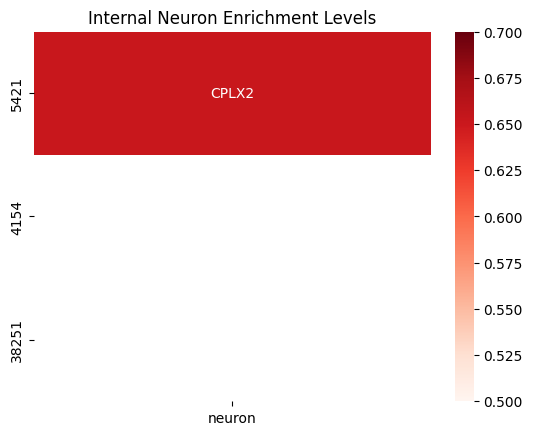

In [177]:
# internal neuron targets
int_neuron = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "internal", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "neuron", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.5,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )

int_neuron_expression = expression_data[expression_data.index.isin(int_neuron)]

tso_indiv = tspex.TissueSpecificity(
    int_neuron_expression, "tsi", log=True
)

tso_indiv_df = pd.DataFrame(
    tso_indiv.tissue_specificity,
    columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
    )

tso_indiv_filtered = tso_indiv_df[tso_indiv_df["neuron"] > 0.5]

neuro_hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data[hgnc_uniprot_mapping_data["uniprot_ids"].isin(int_neuron)]
expressed_targets = tso_indiv_filtered.merge(neuro_hgnc_uniprot_mapping_data, left_index = True, right_on = "uniprot_ids", how = "outer")

neuro_enrich_df = expressed_targets[["neuron", "symbol"]]
cmap = sns.color_palette("Reds", as_cmap=True)
ax = sns.heatmap(neuro_enrich_df[['neuron']], annot=neuro_enrich_df[['symbol']], fmt='', cmap=cmap, cbar=True, vmin = 0.5, vmax = 0.7)
plt.title('Internal Neuron Enrichment Levels')
plt.show()

In [178]:
int_neuron

{'O76039', 'Q6PUV4', 'Q9UI15'}

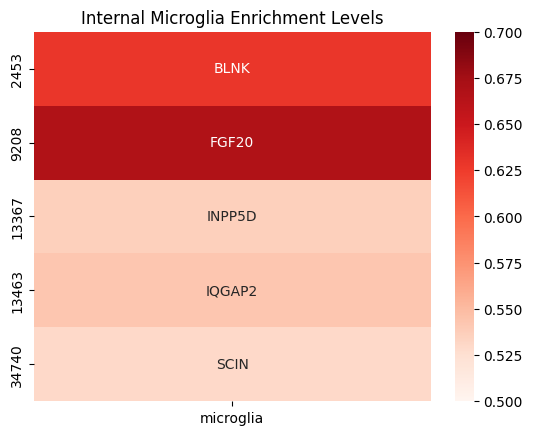

In [50]:
# internal microglia targets
int_microglia = identify_fractionation_pattern_cell_type_specific_targets(
    assays_path = assay_list_path, 
    uniprot_fasta_database = uniprot_fasta_database, 
    region = "internal", 
    brain_rna_seq_path = brain_rna_seq_path,
    cell_type = "microglia", 
    specificity_metric = "tsi", 
    specificity_cutoff = 0.5,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    tidy_dataframe = tidy_data
    )

int_microglia_expression = expression_data[expression_data.index.isin(int_microglia)]

tso_indiv = tspex.TissueSpecificity(
    int_microglia_expression, "tsi", log=True
)

tso_indiv_df = pd.DataFrame(
    tso_indiv.tissue_specificity,
    columns=["endothelial", "astrocyte", "microglia", "neuron", "oligodendrocyte"],
    )

tso_indiv_filtered = tso_indiv_df[tso_indiv_df["microglia"] > 0.5]

microglia_hgnc_uniprot_mapping_data = hgnc_uniprot_mapping_data[hgnc_uniprot_mapping_data["uniprot_ids"].isin(int_microglia)]
expressed_targets = tso_indiv_filtered.merge(microglia_hgnc_uniprot_mapping_data, left_index = True, right_on = "uniprot_ids", how = "outer")

microglia_enrich_df = expressed_targets[["microglia", "symbol"]]
cmap = sns.color_palette("Reds", as_cmap=True)
ax = sns.heatmap(microglia_enrich_df[['microglia']], annot=microglia_enrich_df[['symbol']], fmt='', cmap=cmap, cbar=True, vmin = 0.5, vmax = 0.7)
plt.title('Internal Microglia Enrichment Levels')
plt.show()

In [84]:
CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    # "CSF A Internal EV",
    # "CSF B Internal EV",
    # "CSF C Internal EV",
    # "CSF D Internal EV",
]


def graph_medians(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df[df.index.get_level_values("Health") == "Healthy"]

    df = df.reset_index(level=["SampleID", "Health", "Sample"])

    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)

    df_sorted = df.sort_values("Sample")

    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]

    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)

    plt.xlabel("Sample Description")

    plt.ylabel("Delta")

    plt.title(f"CD63 Fractionation Pattern")

    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)

    plt.xticks(rotation=45, ha="right")

    plt.show()

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_8352\1002580544.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group[uniprot_id].values for name, group in df_sorted.groupby("Sample")


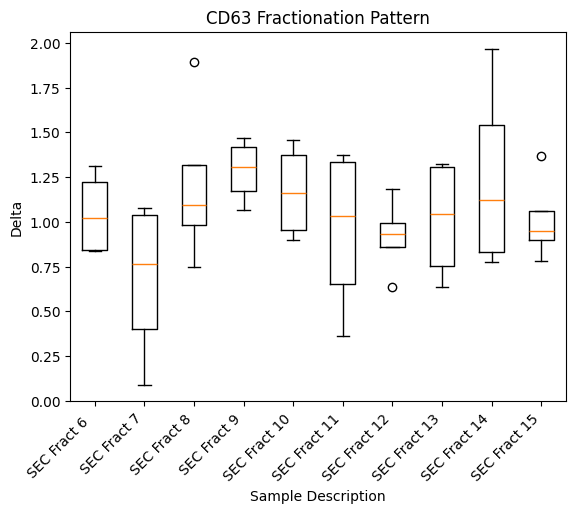

In [85]:
graph_medians("O75528")

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_25432\3506451465.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy_sec_cd63["Sample"] = pd.Categorical(healthy_sec_cd63["Sample"], categories = CSF_SAMPLES, ordered = True)
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_25432\3506451465.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_values = cd63_sorted.groupby("Sample")["P08962"].median()
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_25432\3506451465.py:22: FutureWarning: The default of observed=False is deprecated and will be change

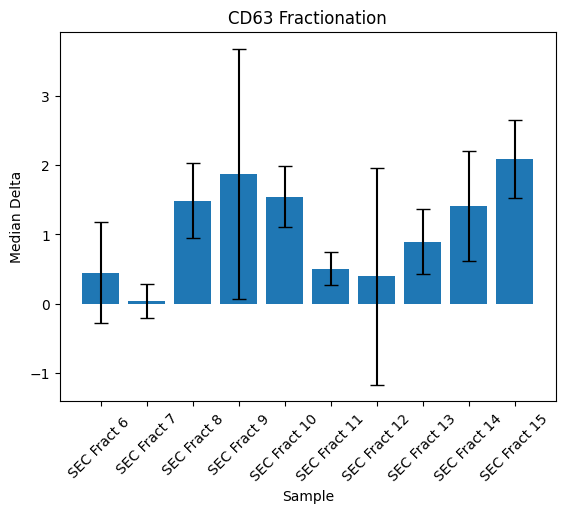

In [ ]:
CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
]

healthy_cd63 = tidy_data[(tidy_data.index.get_level_values("Health") == "Healthy")][["P08962"]]
healthy_sec_cd63 = healthy_cd63[healthy_cd63.index.get_level_values("Sample").str.contains("SEC")]

healthy_sec_cd63.reset_index(level = ["SampleID", "Health", "Sample"], inplace = True)
healthy_sec_cd63["Sample"] = pd.Categorical(healthy_sec_cd63["Sample"], categories = CSF_SAMPLES, ordered = True)
cd63_sorted = healthy_sec_cd63.sort_values("Sample")

median_values = cd63_sorted.groupby("Sample")["P08962"].median()
std_deviation = cd63_sorted.groupby("Sample")["P08962"].std()

plt.bar(median_values.index, median_values, yerr=std_deviation, capsize=5)
plt.xlabel("Sample")
plt.ylabel("Median Delta")
plt.title("CD63 Fractionation")
plt.xticks(rotation=45)
plt.show()


In [ ]:
sample_list = ["CSF1", "CSF2", "CSF3", "CSF4", "CSF5", "CSF6", "CSF7", "CSF8"]
def graph_samples(uniprot_id):
    df = tidy_data[uniprot_id]
    df = df.reset_index()
    for sample in sample_list:
        sample_df = df[df["CSF_sample"] == sample]
        plt.bar(sample_df["Sample"], sample_df[uniprot_id], color = "black")
        plt.xlabel("Sample")
        plt.ylabel("Delta")
        plt.xticks(rotation=90)
        plt.title(f"{uniprot_id} {sample}")

        plt.show()
        

In [ ]:
values = analyze_fractionation(tidy_data, ['9', '10'], ['7', '11', '12', '13',], sample_health = "healthy", mean_median_individual = "individual_median")

external_assays = identify_localization(assays, "external")
internal_assays = identify_localization(assays, "internal")
tm_assays = identify_localization(assays, "TMhelix")

In [ ]:
tm_fract = (set(values) & set(tm_assays))
tm_no_fract = set(values) - set(tm_assays)

tm_values = [len(tm_fract), len(tm_no_fract)]
labels = ["EV Peak", "No EV Peak"]
colors = ["palevioletred", "steelblue"]

plt.pie(tm_values, labels = labels, autopct = '%.2f', colors = colors)
plt.title("Proportion of Transmembrane Proteins With and Without EV Peak")
plt.show()

In [ ]:
int_fract = (set(values) & set(internal_assays))
int_no_fract = set(values) - set(internal_assays)

int_values = [len(int_fract), len(int_no_fract)]
labels = ["EV Peak", "No EV Peak"]
colors = ["c", "m"]

plt.pie(int_values, labels = labels, autopct = '%.2f', colors = colors)
plt.title("Proportion of Internal Proteins With and Without EV Peak")
plt.show()

In [ ]:
ext_fract = (set(values) & set(external_assays))
ext_no_fract = set(values) - set(external_assays)

ext_values = [len(ext_fract), len(ext_no_fract)]
labels = ["EV Peak", "No EV Peak"]
colors = ["palevioletred", "steelblue"]

plt.pie(ext_values, labels = labels, autopct = '%.2f', colors = colors)
plt.title("Proportion of External Proteins With and Without EV Peak")
plt.show()